# MolSHAP

In [1]:
import pandas as pd
from compchemkit.fingerprints import FragmentFingerprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, root_mean_squared_error
from rdkit import Chem
from tqdm.auto import tqdm
from shap import TreeExplainer
import shap
from molshap.maccs_smarts import MACCS_KEYS

<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/home/bob/projects/MolSHAP/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
log_p_data_df = pd.read_csv("../data/logP.csv")

In [3]:
[c for c in log_p_data_df.columns if "log" in c]
[c for c in log_p_data_df.columns if "SMILES" in c]

['SMILES', 'Canonical SMILES']

In [4]:
log_p_data_df = log_p_data_df.query("`Canonical SMILES` != '--'")
log_p_data_df = log_p_data_df.loc[log_p_data_df["Canonical SMILES"].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

In [5]:
dummy_smarts = MACCS_KEYS.values()

In [6]:
smarts_fp = FragmentFingerprint(substructure_list=dummy_smarts)

In [7]:
performance_dict_list = []
for i, (train_idx, test_idx) in enumerate(KFold().split(log_p_data_df["Canonical SMILES"])):
    fp_train = smarts_fp.fit_transform_smiles(log_p_data_df.iloc[train_idx]["Canonical SMILES"])
    model = RandomForestRegressor()
    model.fit(fp_train, log_p_data_df.iloc[train_idx]["logP"])
    fp_test = smarts_fp.fit_transform_smiles(log_p_data_df.iloc[test_idx]["Canonical SMILES"])
    test_prediction = model.predict(fp_test)
    performance_dict_list.append({
        "trial": i,
        "rmsd": root_mean_squared_error(log_p_data_df.iloc[test_idx]["logP"], test_prediction),
        "r2": r2_score(log_p_data_df.iloc[test_idx]["logP"], test_prediction),
    })

In [8]:
pd.DataFrame(performance_dict_list)

,trial,rmsd,r2
0,0,1.004409,0.734648
1,1,0.999850,0.701515
2,2,0.999741,0.709158
3,3,0.846025,0.763260
4,4,0.796763,0.804576


In [9]:
fp_train = smarts_fp.fit_transform_smiles(log_p_data_df.loc[log_p_data_df["Subset"] =="Train", "Canonical SMILES"])
model = RandomForestRegressor(max_depth=32)
model.fit(fp_train, log_p_data_df.loc[log_p_data_df["Subset"] =="Train", "logP"])

,n_estimators,100
,criterion,'squared_error'
,max_depth,32
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
log_p_data_df["Subset"].unique()

array(['Train', 'Validation', 'Blind'], dtype=object)

In [11]:
explainer = TreeExplainer(model=model)

blind_fp = smarts_fp.fit_transform_smiles(log_p_data_df.loc[log_p_data_df["Subset"] =="Blind", "Canonical SMILES"])
feature_importance = explainer(blind_fp.toarray())

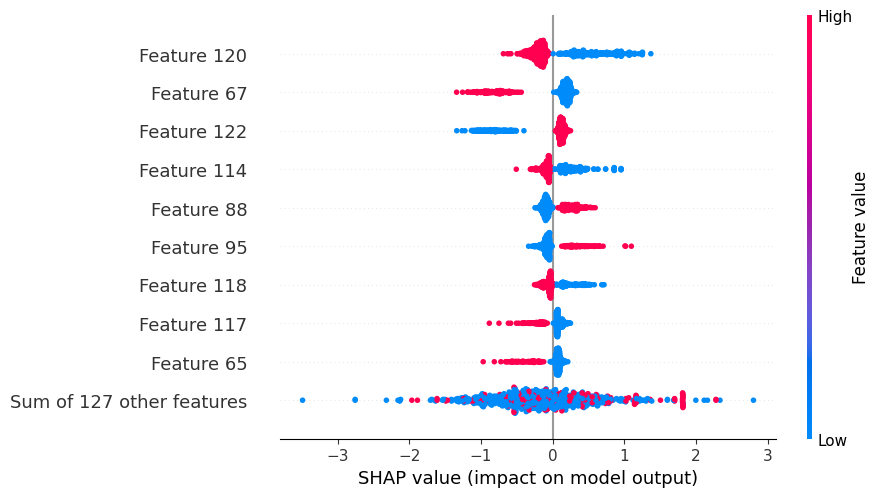

In [14]:
shap.plots.beeswarm(shap_values=feature_importance, )